In [25]:
# !conda install -c conda-forge librosa

# !conda install tqdm

import torch as ch
import torch.nn as nn
import torch.functional as F
import torch.utils.data as Data

import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline

import os
import string
import librosa
import tqdm
import shutil
# !pip install lws
import lws
import IPython.display as ipd
from importlib import reload

import utils
reload(utils)
import hyperparams
reload(hyperparams)
import datasets
reload(datasets)
import dcttsModel
reload(dcttsModel)

<module 'dcttsModel' from '/home/aduriseti/tts/ettts_master/dcttsModel.py'>

In [26]:
dev = ch.device('cuda:0' if ch.cuda.is_available() else 'cpu')
if ch.cuda.is_available():
    ch.multiprocessing.set_start_method("spawn",force=True)

In [27]:
# params = hyperparams.Hyperparams()
ssrnParams = hyperparams.Hyperparams(sep=1,pad=None,chunk=None)
text2MelParams = hyperparams.Hyperparams(sep=0,pad=2)
ssrn = dcttsModel.SSRN(ssrnParams).to(dev)
text2Mel = dcttsModel.Text2Mel(text2MelParams).to(dev)

# print tunable hyperparams
print('TEXT2MEL HYPERPARAMS',text2MelParams.paramDict)
print('SSRN HYPERPARAMS',ssrnParams.paramDict)
[sum(np.prod(p.size()) for p in m.parameters()) for m in (text2Mel,ssrn)]


TEXT2MEL HYPERPARAMS {'sep': 0, 'alpha': 1, 'dropout': 0.05, 'norm': 2, 'lr': 0.001, 'chunk': 1, 'pad': 2, 'reversedDilation': 0}
SSRN HYPERPARAMS {'sep': 1, 'alpha': 1, 'dropout': 0.05, 'norm': 2, 'lr': 0.001, 'reversedDilation': 0}


[23949552, 24980141]

In [28]:
class DbinLoss(ch.nn.Module):
    def __init__(self):
        super(DbinLoss,self).__init__()
    
    def forward(self,Yhat,Y):
        EPS = 1e-12
        elLoss = -(Y*ch.log(Yhat+EPS)+(1-Y)*ch.log(1-Yhat+EPS))
#         return elLoss.view(elLoss.shape[0],-1).mean(1)
        return elLoss.mean()

class GAttLoss(ch.nn.Module):
    def __init__(self):
        super(GAttLoss,self).__init__()
            
    def forward(self,A,I):
        b,N,T = A.shape
        assert I.shape == (b,)
        if text2MelParams.pad == 2:
            W = ch.Tensor([[[np.e**(-(n/N-(t-i)/T)**2 / (2*text2MelParams.g**2)) 
                             for t in range(1,T+1)] 
                            for n in range(1,N+1)]
                           for i in range(b)])
        else:
            W = ch.Tensor([[np.e**(-(n/N-t/T)**2 / (2*text2MelParams.g**2)) 
                             for t in range(1,T+1)] 
                            for n in range(1,N+1)])
        W = W.to(dev)
        return ((1-W)*A).mean()



L1Fun = ch.nn.L1Loss()
BCEFun = ch.nn.BCELoss()
def SpecLossFun(Shat,S): return L1Fun(Shat,S) + BCEFun(Shat,S)
DbinFun = DbinLoss()
GAttFun = GAttLoss()

In [29]:
def text2MelLossFun(text2Mel,batch):
    bL,bS,_,bI = batch
    Shat,A = text2Mel(bL,bS)
    melLoss = SpecLossFun(Shat[:,:,:-text2Mel.params.chunk],bS[:,:,text2Mel.params.chunk:])
#     print(bI)
    attLoss = GAttFun(A,bI)
    return melLoss + attLoss

def text2MelDispFun(text2Mel,batch):
    bL,bS,bY,i = [t[0:1] for t in batch] # only use first element of batch
    print([bL.shape,bS.shape,bY.shape,i.shape])
    print('LOSS:',text2MelLossFun(text2Mel,batch).item())
    Shat,A = text2Mel(bL,bS)
    bL,bS,Shat,A,bY,i = [t[0].cpu().detach().numpy() for t in (bL,bS,Shat,A,bY,i)]
    print('PAD INDEX',i)
    print('TEXT',"".join(text2Mel.params.i2c[c] for c in bL))
    plt.imshow(bS,cmap='gray')
    plt.show()
    plt.imshow(Shat,cmap='gray')
    plt.show()
    plt.imshow(A,cmap='gray')
    plt.show()

In [32]:
text2MelParams = hyperparams.Hyperparams(sep=0,pad=0,reversedDilation=0)
# nWorkers = 8 if ch.cuda.is_available() else 0
nWorkers = 6 if ch.cuda.is_available() else 0
text2MelLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=1,params=text2MelParams),
                                 batch_size=16,
                                 shuffle=True,
                                 num_workers=nWorkers)
text2Mel = dcttsModel.Text2Mel(text2MelParams).to(dev)
text2MelOpt = ch.optim.Adam(text2Mel.parameters(),lr=text2MelParams.lr,
                            betas=(text2MelParams.b1,text2MelParams.b2),
                            eps=text2MelParams.eps)
text2MelWrapper = utils.ModelWrapper(network=text2Mel,optimizer=text2MelOpt,
                                     lossFun=text2MelLossFun,loader=text2MelLoader,
                                     modelName='text2Mel',dev=dev,dispFun=text2MelDispFun)

INITIALIZED text2Mel WITH HYPERPARAMS {'sep': 0, 'alpha': 1, 'dropout': 0.05, 'norm': 2, 'lr': 0.001, 'chunk': 1, 'pad': 0, 'reversedDilation': 0}
TOTAL PARAM COUNT 23949552


EPOCH 0



epoch 0 total 0.04561903830895673
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.03220074996352196
PAD INDEX 0
TEXT the city is divided into two portions by the river which runs through the midst of it.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


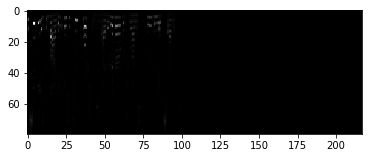

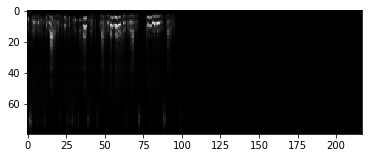

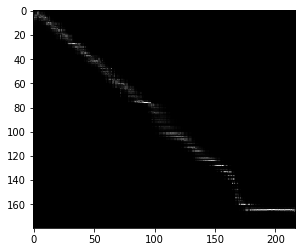

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 1, LOSS 0.04561903830895673, BEST LOSS 0.04561903830895673 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 1


KeyboardInterrupt: 

In [33]:
text2MelWrapper.train(numEpochs=100)

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1
LOADED EPOCH 218, LOSS 0.024148029817351653, BEST LOSS 0.02413702959389384 FROM ./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1/text2MelLast.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar


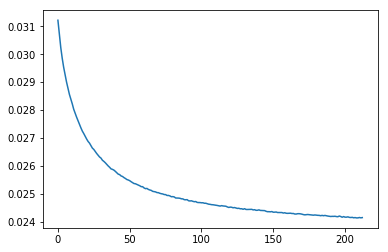

In [9]:
text2MelWrapper.load()
plt.plot(text2MelWrapper.lossHist[5:])

In [10]:
def ssrnLossFun(ssrn,batch):
    _,bS,bY,_ = batch
    Yhat = ssrn(bS)
    return SpecLossFun(Yhat,bY)

def ssrnDispFun(ssrn,batch):
    bL,bS,bY,i = [t[0:1] for t in batch] # only use first element of batch
#     print([t.device for t in batch])
    print('LOSS:',ssrnLossFun(ssrn,batch).item())
    print(bS.shape)
    Yhat = ssrn(bS)
    bL,bS,bY,Yhat,i = [t[0].cpu().detach().numpy() for t in (bL,bS,bY,Yhat,i)]
    print('PAD INDEX',i)
    print('TEXT',"".join(ssrn.params.i2c[c] for c in bL))
    plt.imshow(bS,cmap='gray')
    plt.show()
    plt.imshow(bY,cmap='gray')
    plt.show()
    plt.imshow(Yhat,cmap='gray')
    plt.show()

In [11]:
ssrnParams = hyperparams.Hyperparams(sep=0)
# nWorkers = 8 if ch.cuda.is_available() else 0
nWorkers = 6 if ch.cuda.is_available() else 0
ssrnLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=0),
                             batch_size=16,
                             shuffle=True,
                             num_workers=nWorkers)
ssrn = dcttsModel.SSRN(ssrnParams).to(dev)
ssrnOpt = ch.optim.Adam(ssrn.parameters(),lr=ssrnParams.lr,
                        betas=(ssrnParams.b1,ssrnParams.b2),
                        eps=ssrnParams.eps)
ssrnWrapper = utils.ModelWrapper(network=ssrn,optimizer=ssrnOpt,
                                 lossFun=ssrnLossFun,loader=ssrnLoader,
                                 modelName='ssrn',dev=dev,dispFun=ssrnDispFun)

INITIALIZED ssrn WITH HYPERPARAMS {'sep': 0, 'alpha': 1, 'dropout': 0.05, 'norm': 2, 'lr': 0.001, 'chunk': 1, 'pad': 0, 'reversedDilation': 0}
TOTAL PARAM COUNT 24980141


In [12]:
ssrnWrapper.load()

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
LOADED EPOCH 50, LOSS 0.09994267415422112, BEST LOSS 0.09986980878817502 FROM ./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar


EPOCH 50



epoch 50 total 0.09986149603083952
LOSS: 0.10600095987319946
torch.Size([1, 80, 64])
PAD INDEX 35
TEXT and continued his march to kingston, where he slept soundly under a hedge till next morning.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


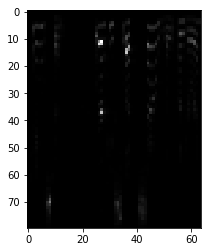

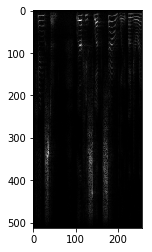

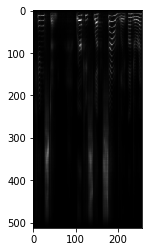

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 51, LOSS 0.09986149603083952, BEST LOSS 0.09986149603083952 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 51



epoch 51 total 0.09979430143512896
LOSS: 0.08096517622470856
torch.Size([1, 80, 64])
PAD INDEX 15
TEXT he cried out, quote, oh, no, no, no. my god, they are going to kill us all, end quote,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


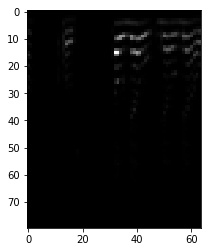

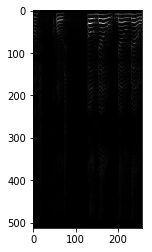

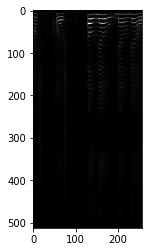

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 52, LOSS 0.09979430143512896, BEST LOSS 0.09979430143512896 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 52


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 54 total 0.09992597666916563
LOSS: 0.07791224867105484
torch.Size([1, 80, 64])
PAD INDEX 67
TEXT the revolver shipped from los angeles on the same date, and the two newspapers which he was holding in the picture.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


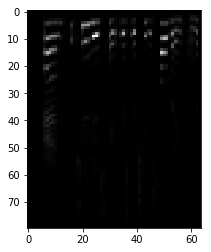

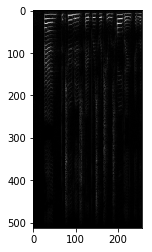

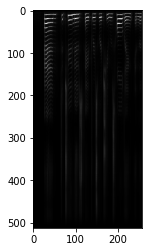

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 55, LOSS 0.09992597666916563, BEST LOSS 0.09979430143512896 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 55



epoch 55 total 0.09980544473475485
LOSS: 0.0962112620472908
torch.Size([1, 80, 64])
PAD INDEX 9
TEXT the inspector said that they could not be removed till he reached england.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


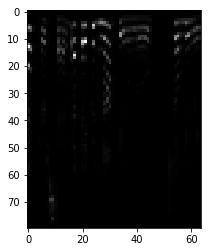

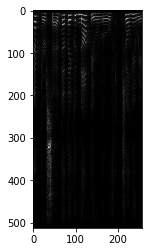

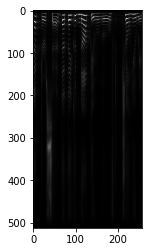

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 56, LOSS 0.09980544473475485, BEST LOSS 0.09979430143512896 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 56



epoch 56 total 0.09978167975126807
LOSS: 0.10723195225000381
torch.Size([1, 80, 64])
PAD INDEX 7
TEXT was tried at the old bailey the following year for horse-stealing, and hanged in front of newgate.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


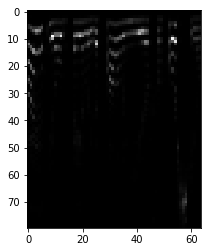

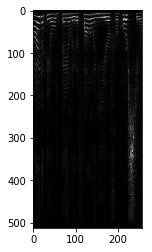

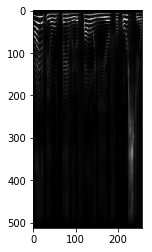

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 57, LOSS 0.09978167975126807, BEST LOSS 0.09978167975126807 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 57


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 59 total 0.09966794914051667
LOSS: 0.12096200883388519
torch.Size([1, 80, 64])
PAD INDEX 87
TEXT ronald simmons, chief of the u.s. army infantry weapons evaluation branch of the ballistics research laboratory, said, quote,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


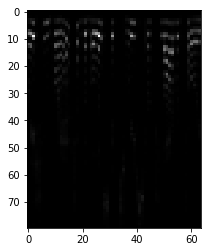

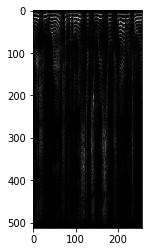

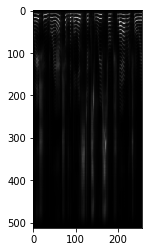

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 60, LOSS 0.09966794914051667, BEST LOSS 0.09966794914051667 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 60



epoch 60 total 0.09987756476473453
LOSS: 0.09619195014238358
torch.Size([1, 80, 64])
PAD INDEX 32
TEXT animals, on the contrary, derive their nourishment either directly or indirectly from plants.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


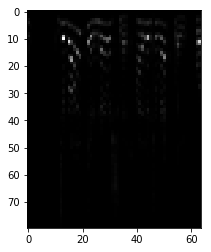

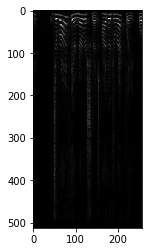

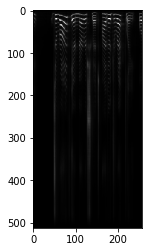

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 61, LOSS 0.09987756476473453, BEST LOSS 0.09966794914051667 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 61


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 64 total 0.09965874139052719
LOSS: 0.09138160943984985
torch.Size([1, 80, 64])
PAD INDEX 16
TEXT and to keep the secretary fully informed regarding all significant developments relating to presidential protection.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


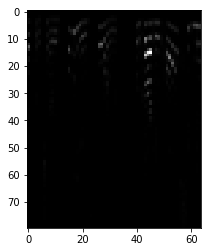

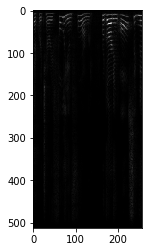

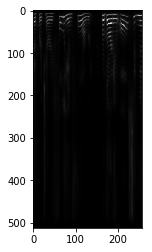

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 65, LOSS 0.09965874139052719, BEST LOSS 0.09965874139052719 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 65



epoch 65 total 0.09967055832272145
LOSS: 0.08944829553365707
torch.Size([1, 80, 64])
PAD INDEX 43
TEXT there lie the ruins of the famous temple of esagil, sacred to marduk.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


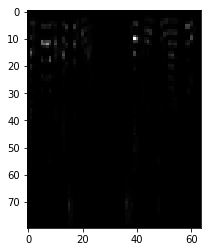

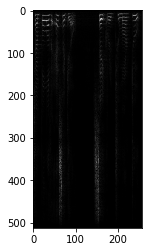

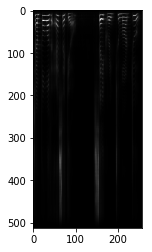

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 66, LOSS 0.09967055832272145, BEST LOSS 0.09965874139052719 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 66


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 69 total 0.09957076048673089
LOSS: 0.08903147280216217
torch.Size([1, 80, 64])
PAD INDEX 61
TEXT if oswald left his roominghouse shortly after one p.m. and walked at a brisk pace,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


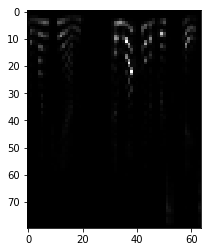

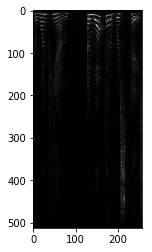

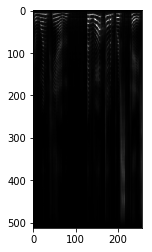

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 70, LOSS 0.09957076048673089, BEST LOSS 0.09954169322528056 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 70



epoch 70 total 0.099595432027952
LOSS: 0.11309492588043213
torch.Size([1, 80, 64])
PAD INDEX 2
TEXT all of the ancient writers agree in saying that babylon was surrounded with both inner and outer walls, and the ruins confirm their statements.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


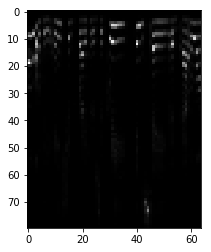

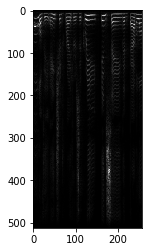

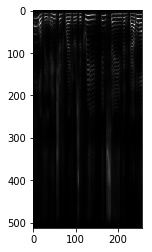

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 71, LOSS 0.099595432027952, BEST LOSS 0.09954169322528056 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 71


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 74 total 0.09960629180518549
LOSS: 0.0997563824057579
torch.Size([1, 80, 64])
PAD INDEX 8
TEXT these were the missing members of the same mutilated trunk,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


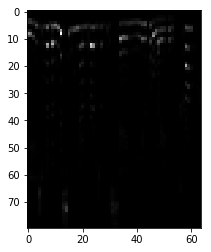

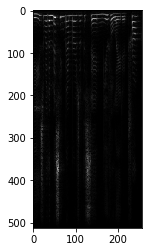

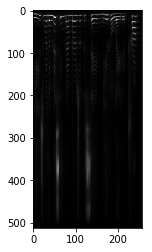

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 75, LOSS 0.09960629180518549, BEST LOSS 0.09949982487666073 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 75



epoch 75 total 0.09951237804854095
LOSS: 0.10678763687610626
torch.Size([1, 80, 64])
PAD INDEX 4
TEXT although in the phone conversation she described the man as, quote, short, end quote, on november twenty-second,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


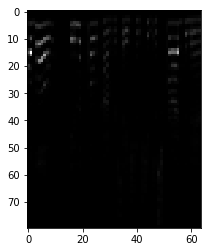

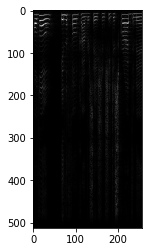

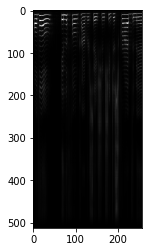

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 76, LOSS 0.09951237804854095, BEST LOSS 0.09949982487666073 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 76


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 79 total 0.09946537838498158
LOSS: 0.09543736279010773
torch.Size([1, 80, 64])
PAD INDEX 24
TEXT he had friends and auxiliaries inside the jail and out. the cell he occupied was near the outer wall,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


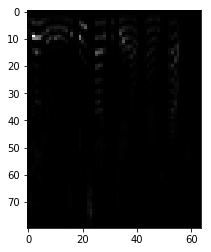

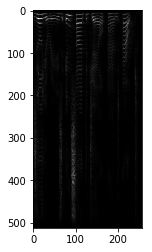

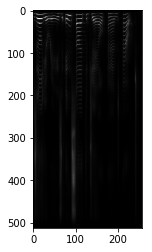

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 80, LOSS 0.09946537838498158, BEST LOSS 0.09941901085314465 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 80



epoch 80 total 0.09951475189248128
LOSS: 0.09538190066814423
torch.Size([1, 80, 64])
PAD INDEX 0
TEXT after the birth of their second child.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


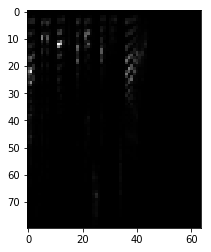

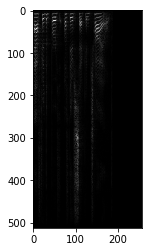

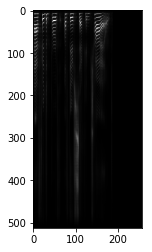

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 81, LOSS 0.09951475189248128, BEST LOSS 0.09941901085314465 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 81


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 84 total 0.09946790148517978
LOSS: 0.10112490504980087
torch.Size([1, 80, 64])
PAD INDEX 4
TEXT sought about for a fresh victim to supply him with funds.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


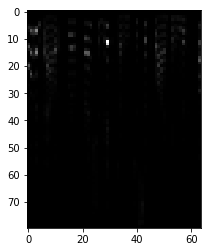

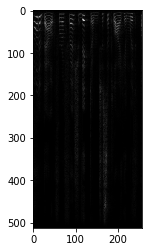

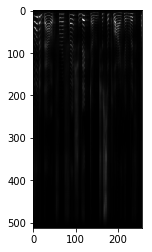

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 85, LOSS 0.09946790148517978, BEST LOSS 0.09936193065412009 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 85



epoch 85 total 0.09944298557603537
LOSS: 0.11154619604349136
torch.Size([1, 80, 64])
PAD INDEX 29
TEXT i asked him where he wanted to go. and he said, "five hundred north beckley. well, i started up,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


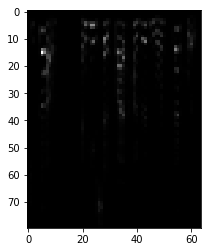

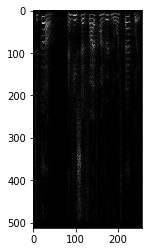

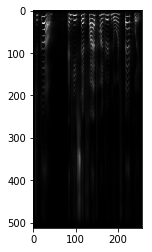

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 86, LOSS 0.09944298557603537, BEST LOSS 0.09936193065412009 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 86



epoch 86 total 0.0995214815571237
LOSS: 0.10975310206413269
torch.Size([1, 80, 64])
PAD INDEX 50
TEXT none of these employees except oswald left identifiable prints on the cartons.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


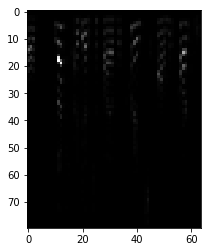

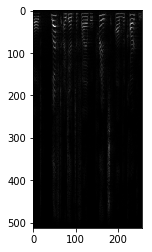

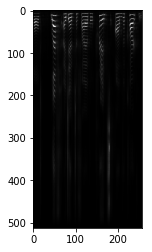

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 87, LOSS 0.0995214815571237, BEST LOSS 0.09936193065412009 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 87


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 89 total 0.09934094197936912
LOSS: 0.10501707345247269
torch.Size([1, 80, 64])
PAD INDEX 70
TEXT the next time thain entered his cabin he fired at him point-blank, and lodged three bullets in his breast.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


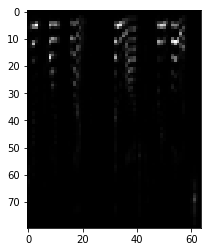

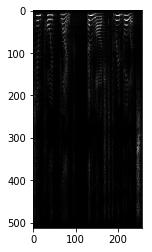

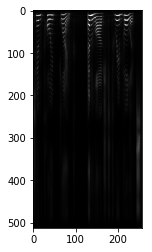

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 90, LOSS 0.09934094197936912, BEST LOSS 0.09934094197936912 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 90



epoch 90 total 0.09933894928266752
LOSS: 0.09458377957344055
torch.Size([1, 80, 64])
PAD INDEX 46
TEXT a very large percentage of newspaper publishers, chambers of commerce,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


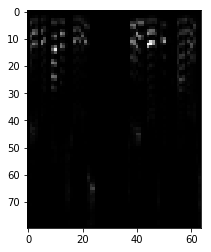

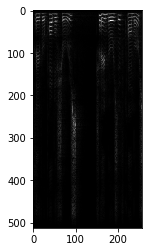

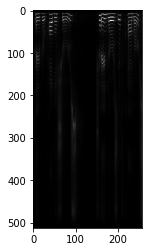

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 91, LOSS 0.09933894928266752, BEST LOSS 0.09933894928266752 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 91



epoch 91 total 0.099248721317124
LOSS: 0.08606483787298203
torch.Size([1, 80, 64])
PAD INDEX 50
TEXT or any of the new establishments at home, at portland, dartmoor, or elsewhere.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


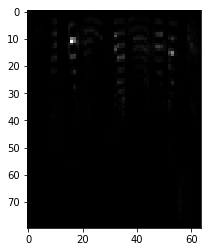

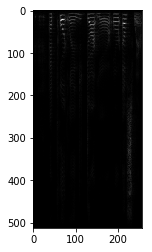

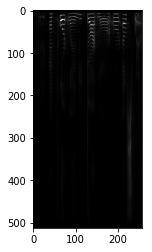

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 92, LOSS 0.099248721317124, BEST LOSS 0.099248721317124 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 92


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 94 total 0.09935165055429758
LOSS: 0.08327939361333847
torch.Size([1, 80, 64])
PAD INDEX 64
TEXT as the evidence he gave incriminated pierce, burgess, and tester, all three were arrested and committed to newgate for trial.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


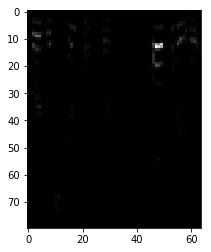

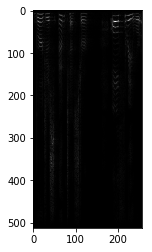

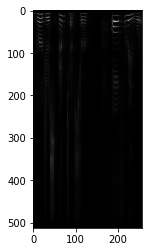

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 95, LOSS 0.09935165055429758, BEST LOSS 0.099248721317124 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 95



epoch 95 total 0.09945693989075831
LOSS: 0.0945117250084877
torch.Size([1, 80, 64])
PAD INDEX 96
TEXT since the assassination, secret service procedures have been changed to require that a member of prs accompany each advance survey teamNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


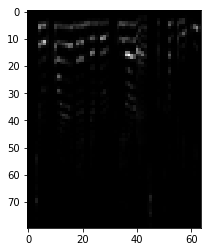

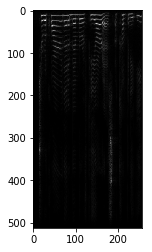

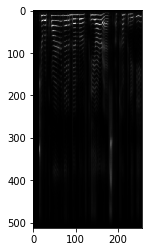

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 96, LOSS 0.09945693989075831, BEST LOSS 0.099248721317124 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 96



epoch 96 total 0.09920273802396076
LOSS: 0.08474671840667725
torch.Size([1, 80, 64])
PAD INDEX 2
TEXT looked forward to his liberty, he was still delayed until he had paid a new debt arising, quote,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


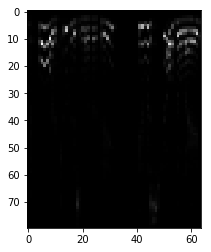

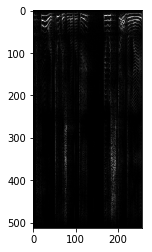

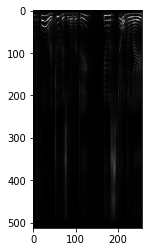

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 97, LOSS 0.09920273802396076, BEST LOSS 0.09920273802396076 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 97


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 99 total 0.09936295776669658
LOSS: 0.1109447032213211
torch.Size([1, 80, 64])
PAD INDEX 0
TEXT in seventeen eighty-nine in less time than it took george washington to travel from new york to mount vernonNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


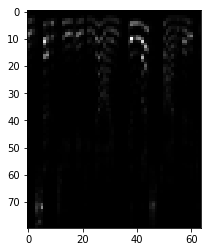

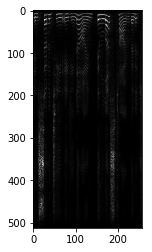

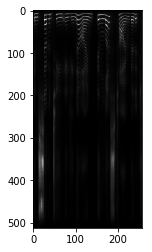

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 100, LOSS 0.09936295776669658, BEST LOSS 0.09920273802396076 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']


In [13]:
ssrnWrapper.train(numEpochs=50)